# Link Analysis
Conducting a link analysis of a network graph involves identifying and analyzing the link within the graph. 

In [1]:
import pandas as pd
import numpy as np
from os.path import join
import os


from dotenv import load_dotenv
load_dotenv()  

path = os.environ['DATA_DIRECTORY']
covalent_key = os.environ['COVALENTHQ_API_KEY']
df_snapshots = pd.read_csv('../data/snapshot_selection.csv')
df_tokens = pd.read_csv("../data/final_token_selection.csv")


In [2]:
import sys
sys.path.append('..') 

from src.analysis.link_analysis import * 
from src.visualisations.link_analysis_visualisations import * 

## Create dataframes for each metrics

In [3]:
TOKEN_BALANCE_TABLE_INPUT_PATH = join(path, "../data/snapshot_token_balance_tables_enriched")


ddf = pd.read_csv(join(TOKEN_BALANCE_TABLE_INPUT_PATH, f'token_holder_snapshot_balance_labelled_14779829.csv'), index_col=0)



In [4]:
f_dict = {'CRV': [11659570, 11659570, 11861210], '1INCH': [11659570, 11659570], 'LDO': [11659570, 11861210, 11861210, 12043054, 12043054], 'INST': [12244515, 12244515, 12244515, 12244515, 12438842, 12438842, 12438842, 12438842], 'CVX': [12638919, 12831436]}

In [5]:
fc_dict = {}

# which cliques cause this 
# direction 
# what is the sample size 
# What is the sample population size 


for key, item in f_dict.items(): 
    
    fc_dict[key] = list(set(item))
    
fc_dict

{'CRV': [11861210, 11659570],
 '1INCH': [11659570],
 'LDO': [11861210, 11659570, 12043054],
 'INST': [12438842, 12244515],
 'CVX': [12831436, 12638919]}

In [6]:
import pickle

# Specify the path to the file containing the saved cliques data
links_data_path = join(path, '../data/links_data_class.pkl')
links_data = LinkData(links_data_path)


# Use the metric_names attribute from CliquesData
metric_names = links_data.metric_names


# Initialize an empty dictionary to store DataFrames for each metric
metric_dataframes = {'sample': {},'control': {},'pvalues': {}, 'sample_directional':{}, 'control_directional':{}, 'pvalues_directional':{}}

# Create DataFrames for each metric
for group in ['sample', 'control', 'pvalues', 'sample_directional', 'control_directional', 'pvalues_directional']:
    for metric_name in metric_names:
        metric_dataframes[group][metric_name] = links_data.get_metric_data(group, metric_name)
        

### TEST ENVIRONMENT FOR DEVELOPMENT OF HEATMAP CHART FOR DIRECTIONAL SAMPLES 

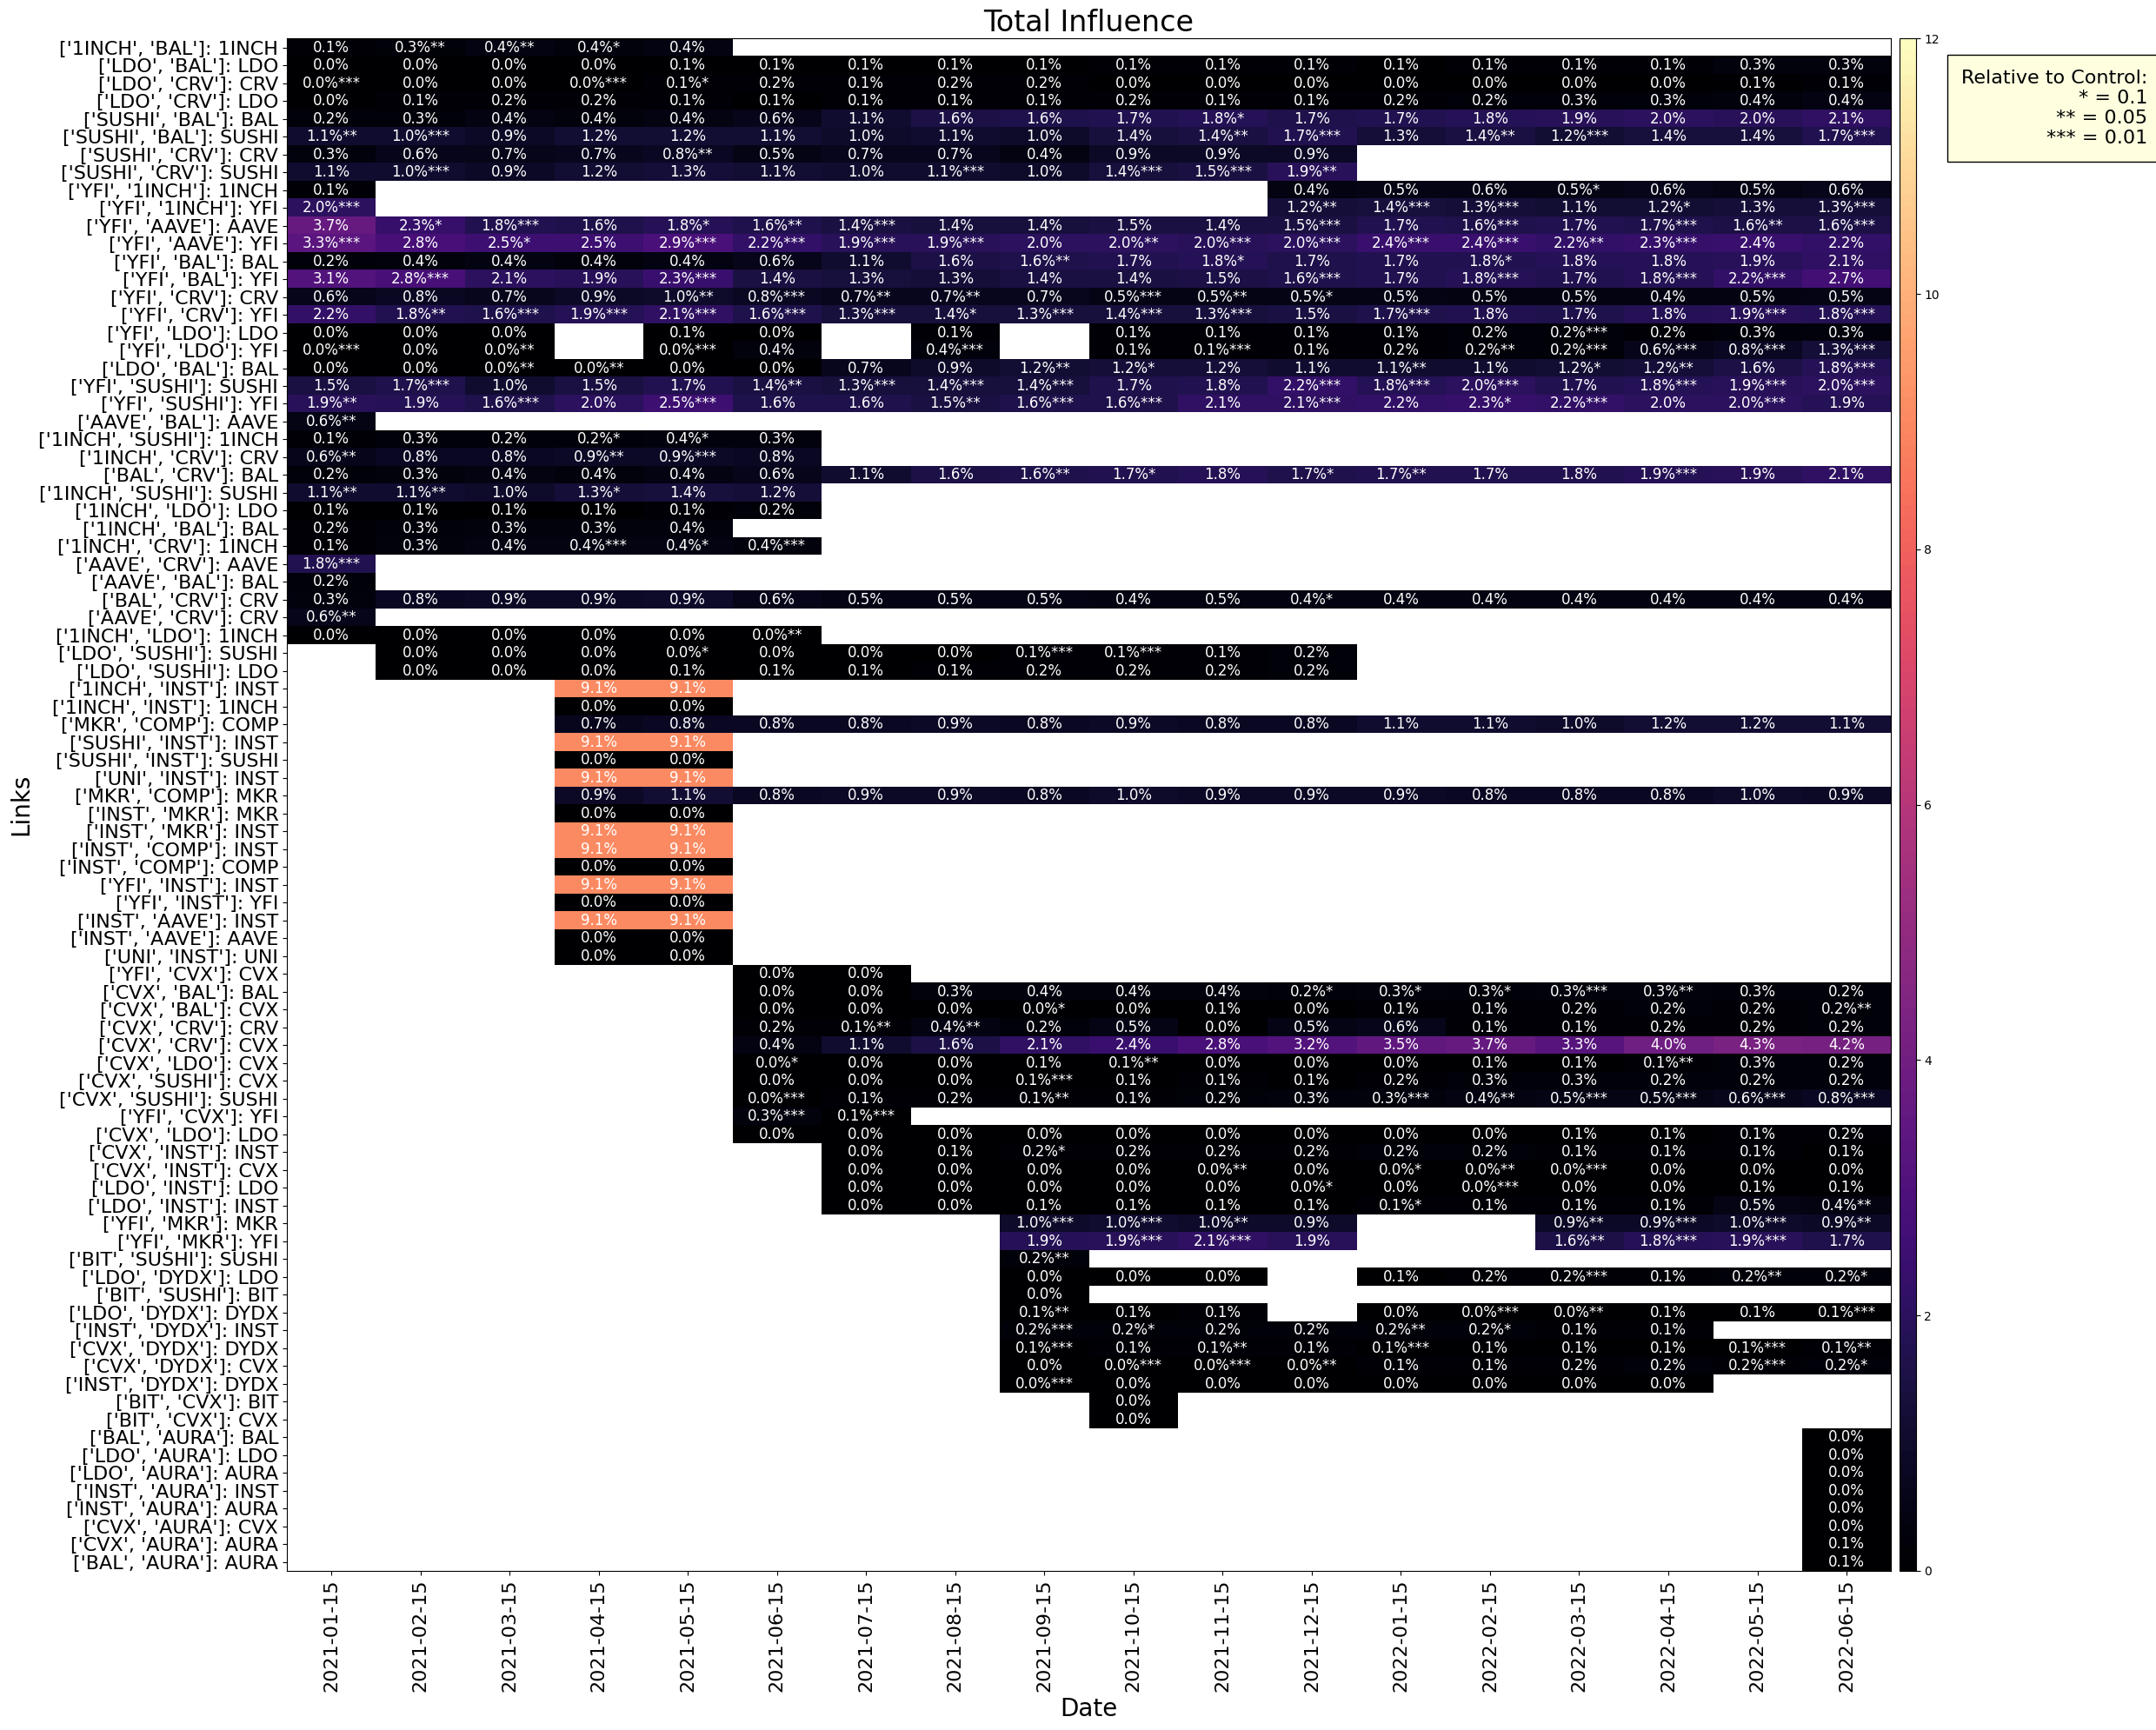

In [8]:
def plot_heatmap_chart_directional(metric_dataframes, metric_name, pct=True, log=False, output_path="../output/links/", save=False, show=True):
    
    if pct==True: 
        multiplier = 100 
        unit='%'
    else: 
        multiplier = 1
        unit=''

    # Define df
    if log == True: 
        df = np.log10(metric_dataframes['sample_directional'][metric_name]) * multiplier
    else: 
        df = metric_dataframes['sample_directional'][metric_name] * multiplier


    df_pv = metric_dataframes['pvalues_directional'][metric_name]
    
    # reindex
    df_index = metric_dataframes['sample_directional'][metric_name] * multiplier

    # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 0).idxmax()
    
    # Determine the minimum index (earliest occurrence) for each clique across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
    
    # Sort the cliques based on their minimum indices to get the desired order
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df= df.reindex(cliques_order)
    df_pv = df_pv.reindex(cliques_order)

    fig, ax = plt.subplots(figsize=FIG_SIZE)

    # Create colormap
    cmap = plt.get_cmap("magma", lut=128)
    norm = mcolors.Normalize(vmin=0, vmax=round(df.max().max()*1.3))

    # Plotting the values
    im = ax.imshow(df, cmap=cmap, norm=norm, aspect='auto', interpolation='none')


    # Colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)  # '2%' determines the width of the colorbar
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    tick_vals = np.array(cbar.get_ticks()) 
    # cbar.set_ticklabels([f'{round(val)}%' for val in tick_vals])
    
    # Significance box
    plt.text(1.16, 0.98, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', 
         transform=ax.transAxes, fontsize=FONT_SIZE_TEXT, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='lightyellow', alpha=1, pad=12))
    # Labels and title
    ax.set_xlabel('Date', size=FONT_SIZE_LABEL)
    ax.set_ylabel('Links', size=FONT_SIZE_LABEL)
    ax.set_title(f'{metric_name.replace("_", " ").title()}', size=FONT_SIZE_TITLE)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(df.columns, rotation=90, ha='center', size=FONT_SIZE_TEXT)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(df.index, size=FONT_SIZE_TEXT)
    plt.grid(False)
    plt.tight_layout()


    # Annotate the values on the plot
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            value = df.values[i, j]
            pval = df_pv.values[i, j]
            pval = pval_to_significance(pval) 
            if not np.isnan(value):
                text = ax.text(j, i, f'{value:.1f}{unit}{pval}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)

    # Save and/or show the plot
    if save:
        plt.savefig(join(output_path, f'{metric_name}_links.png'), bbox_inches='tight')
    if show:
        plt.show()
        
        
plot_heatmap_chart_directional(metric_dataframes, metric_name='total_influence', pct=True, log=False, output_path="../output/links/directional_analysis", save=True, show=True)

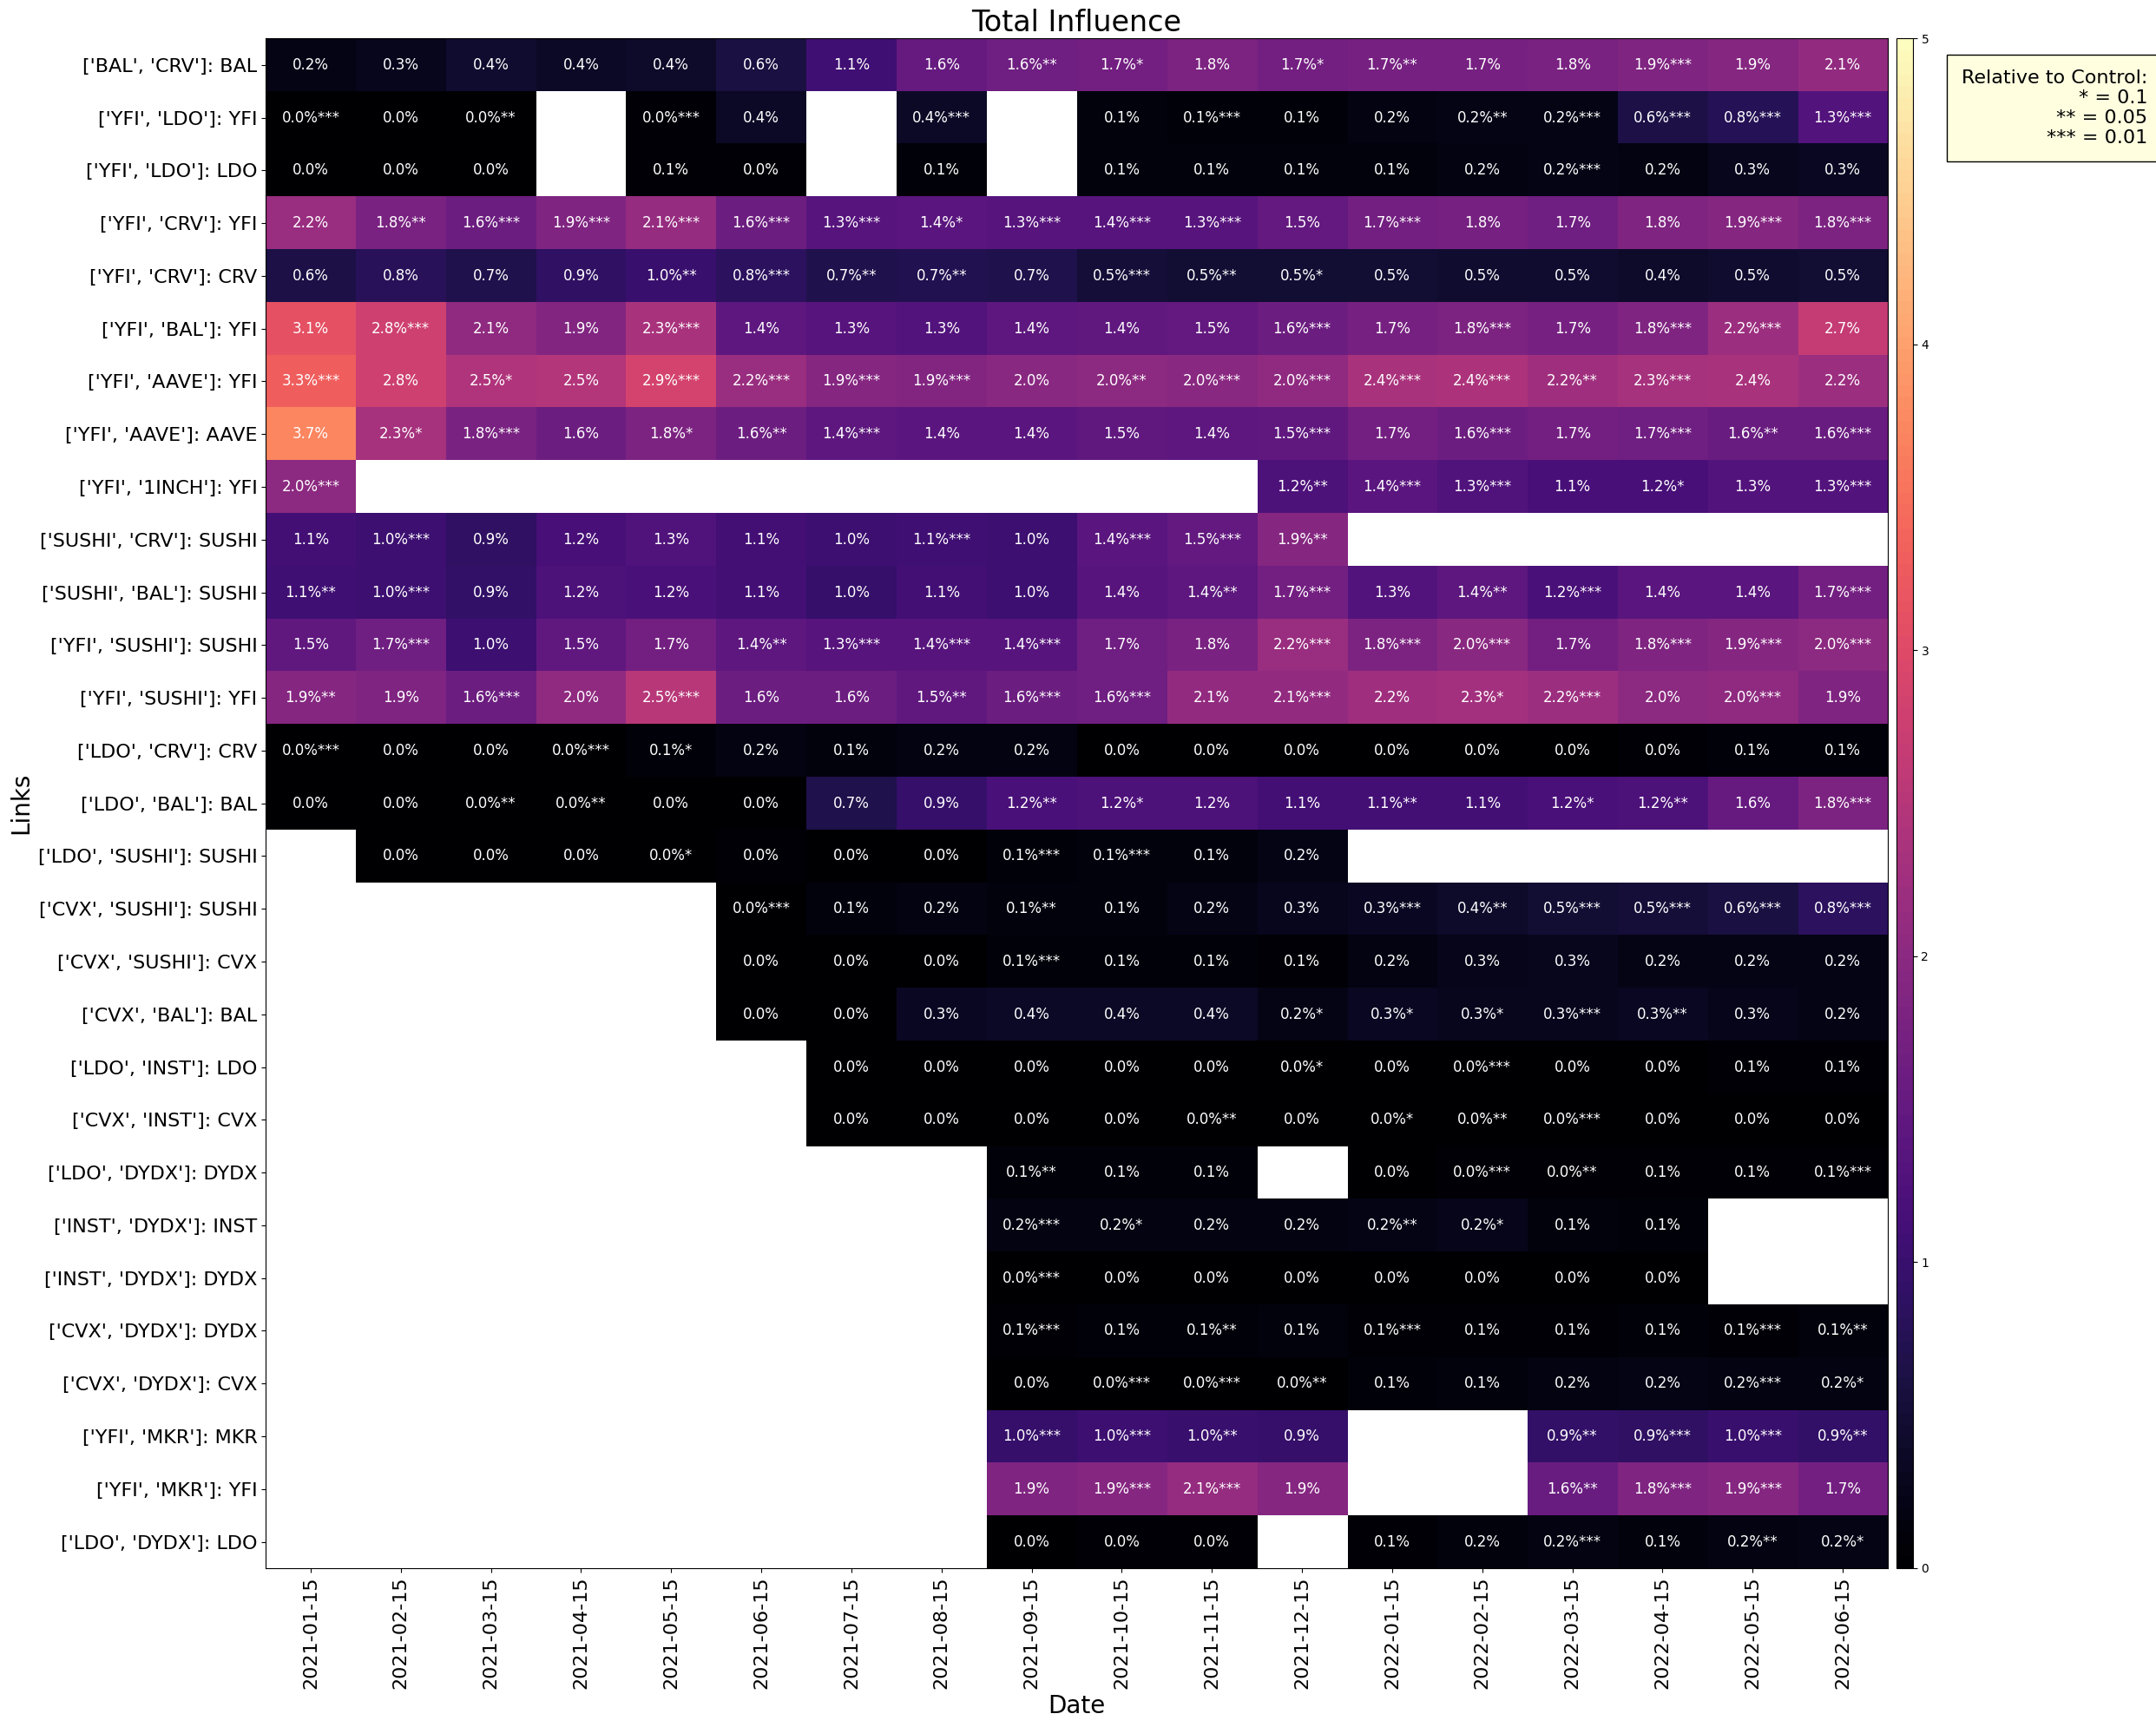

In [44]:
def plot_heatmap_chart_directional(metric_dataframes, metric_name, pct=True, log=False, output_path="../output/links/", save=False, show=True):
    
    if pct==True: 
        multiplier = 100 
        unit='%'
    else: 
        multiplier = 1
        unit=''

    # Define df
    if log == True: 
        df = np.log10(metric_dataframes['sample_directional'][metric_name]) * multiplier
    else: 
        df = metric_dataframes['sample_directional'][metric_name] * multiplier


    df_pv = metric_dataframes['pvalues_directional'][metric_name]
    
    # filter for relevant rows 
    pval_filter = (df_pv <= 0.01).any(axis=1)==True
    
    # updated frames 
    df = df[pval_filter]
    df_pv = df_pv[pval_filter]

    # Additional filtering criterion to exclude links appearing less than once
    # Calculate the number of non-zero occurrences for each row (clique)
    non_zero_counts = (df > 0).sum(axis=1)
    
    # Filter rows where the number of non-zero occurrences is less than 5
    df = df[non_zero_counts > 7]
    df_pv = df_pv.loc[df.index]

    
    # reindex
    df_index = df.copy()

    # Find the index of the first occurrence (value > 1) in each column (snapshot)
    first_occurrence_indices = (df_index.T > 0).idxmax()
    
    # Determine the minimum index (earliest occurrence) for each clique across all snapshots
    min_indices = first_occurrence_indices.groupby(first_occurrence_indices.index).min()
    
    # Sort the cliques based on their minimum indices to get the desired order
    cliques_order = min_indices.sort_values().index.tolist()

    # Reindex clique size to df
    df= df.reindex(cliques_order)
    df_pv = df_pv.reindex(cliques_order)

    fig, ax = plt.subplots(figsize=FIG_SIZE)

    # Create colormap
    cmap = plt.get_cmap("magma", lut=128)
    norm = mcolors.Normalize(vmin=0, vmax=round(df.max().max()*1.3))

    # Plotting the values
    im = ax.imshow(df, cmap=cmap, norm=norm, aspect='auto', interpolation='none')


    # Colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.1)  # '2%' determines the width of the colorbar
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
    tick_vals = np.array(cbar.get_ticks()) 
    # cbar.set_ticklabels([f'{round(val)}%' for val in tick_vals])
    
    # Significance box
    plt.text(1.16, 0.98, 'Relative to Control:\n* = 0.1\n** = 0.05\n*** = 0.01', 
         transform=ax.transAxes, fontsize=FONT_SIZE_TEXT, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(facecolor='lightyellow', alpha=1, pad=12))
    # Labels and title
    ax.set_xlabel('Date', size=FONT_SIZE_LABEL)
    ax.set_ylabel('Links', size=FONT_SIZE_LABEL)
    ax.set_title(f'Directional Analysis: {metric_name.replace("_", " ").title()}', size=FONT_SIZE_TITLE)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(df.columns, rotation=90, ha='center', size=FONT_SIZE_TEXT)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(df.index, size=FONT_SIZE_TEXT)
    plt.grid(False)
    plt.tight_layout()


    # Annotate the values on the plot
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            value = df.values[i, j]
            pval = df_pv.values[i, j]
            pval = pval_to_significance(pval) 
            if not np.isnan(value):
                text = ax.text(j, i, f'{value:.1f}{unit}{pval}', ha='center', va='center', color='white', fontsize=FONT_SIZE_VALUE)

    # Save and/or show the plot
    if save:
        plt.savefig(join(output_path, f'{metric_name}_links.png'), bbox_inches='tight')
    if show:
        plt.show()
        
        
plot_heatmap_chart_directional(metric_dataframes, metric_name='total_influence', pct=True, log=False, output_path="../output/links/directional_analysis", save=True, show=True)

## Figure Generation

### Fig: Size of Clique 

In [ ]:
plot_link_size_over_time(metric_dataframes, group='sample', output_path="../output/links/", save=True, show=True)

### Fig: link growth over time 

In [ ]:
plot_link_growth_over_time(metric_dataframes, group='sample', output_path="../output/links/", save=True, show=True)

In [ ]:
 plot_link_growth_rate_over_time(metric_dataframes, group='sample', output_path="../output/links/", save=True, show=True)

In [ ]:
plot_link_stability_vs_no_of_tokens(metric_dataframes, group='sample', output_path="../output/links/", save=True, show=True)

In [ ]:
plot_link_stability_vs_size(metric_dataframes, group='sample', output_path="../output/links/", save=True, show=True)

### Fig: link_size vs total_influence 

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# from os.path import join

# def plot_clique_size_influence_correlation(metric_dataframes, method='upper_bound', group='sample', output_path="output/cliques/", save=True, show=True):
#     # Define dfs
#     df_size = metric_dataframes[method][group]['size_clique']
#     df_influence = metric_dataframes[method][group]['total_influence']

#     # Calculate correlations for each timestamp
#     correlations = df_size.corrwith(df_influence, axis=0)

#     # Plotting the correlations
#     plt.figure(figsize=(10, 5))
#     plt.plot(correlations.index, correlations, marker='o', linestyle='-')
#     plt.xlabel('Timestamps', fontsize=12)
#     plt.ylabel('Correlation between Clique Size and Total Influence', fontsize=12)
#     plt.title(f'[{method.upper()}]: Correlation of Clique Size and Total Influence Over Time', fontsize=14)
#     plt.grid(True)

#     plt.xticks(rotation=90)  # Rotate x-tick labels by 90 degrees

#     # Save the plot to the specified output path
#     if save:
#         plt.savefig(join(output_path, f'clique_size_influence_correlation_{method}_{group}.png'))

#     if show:
#         plt.show()
#     else:
#         plt.close()

# # Example usage
# plot_clique_size_influence_correlation(metric_dataframes, method='upper_bound', group='sample', save=False, show=True)


### Fig: total_influence

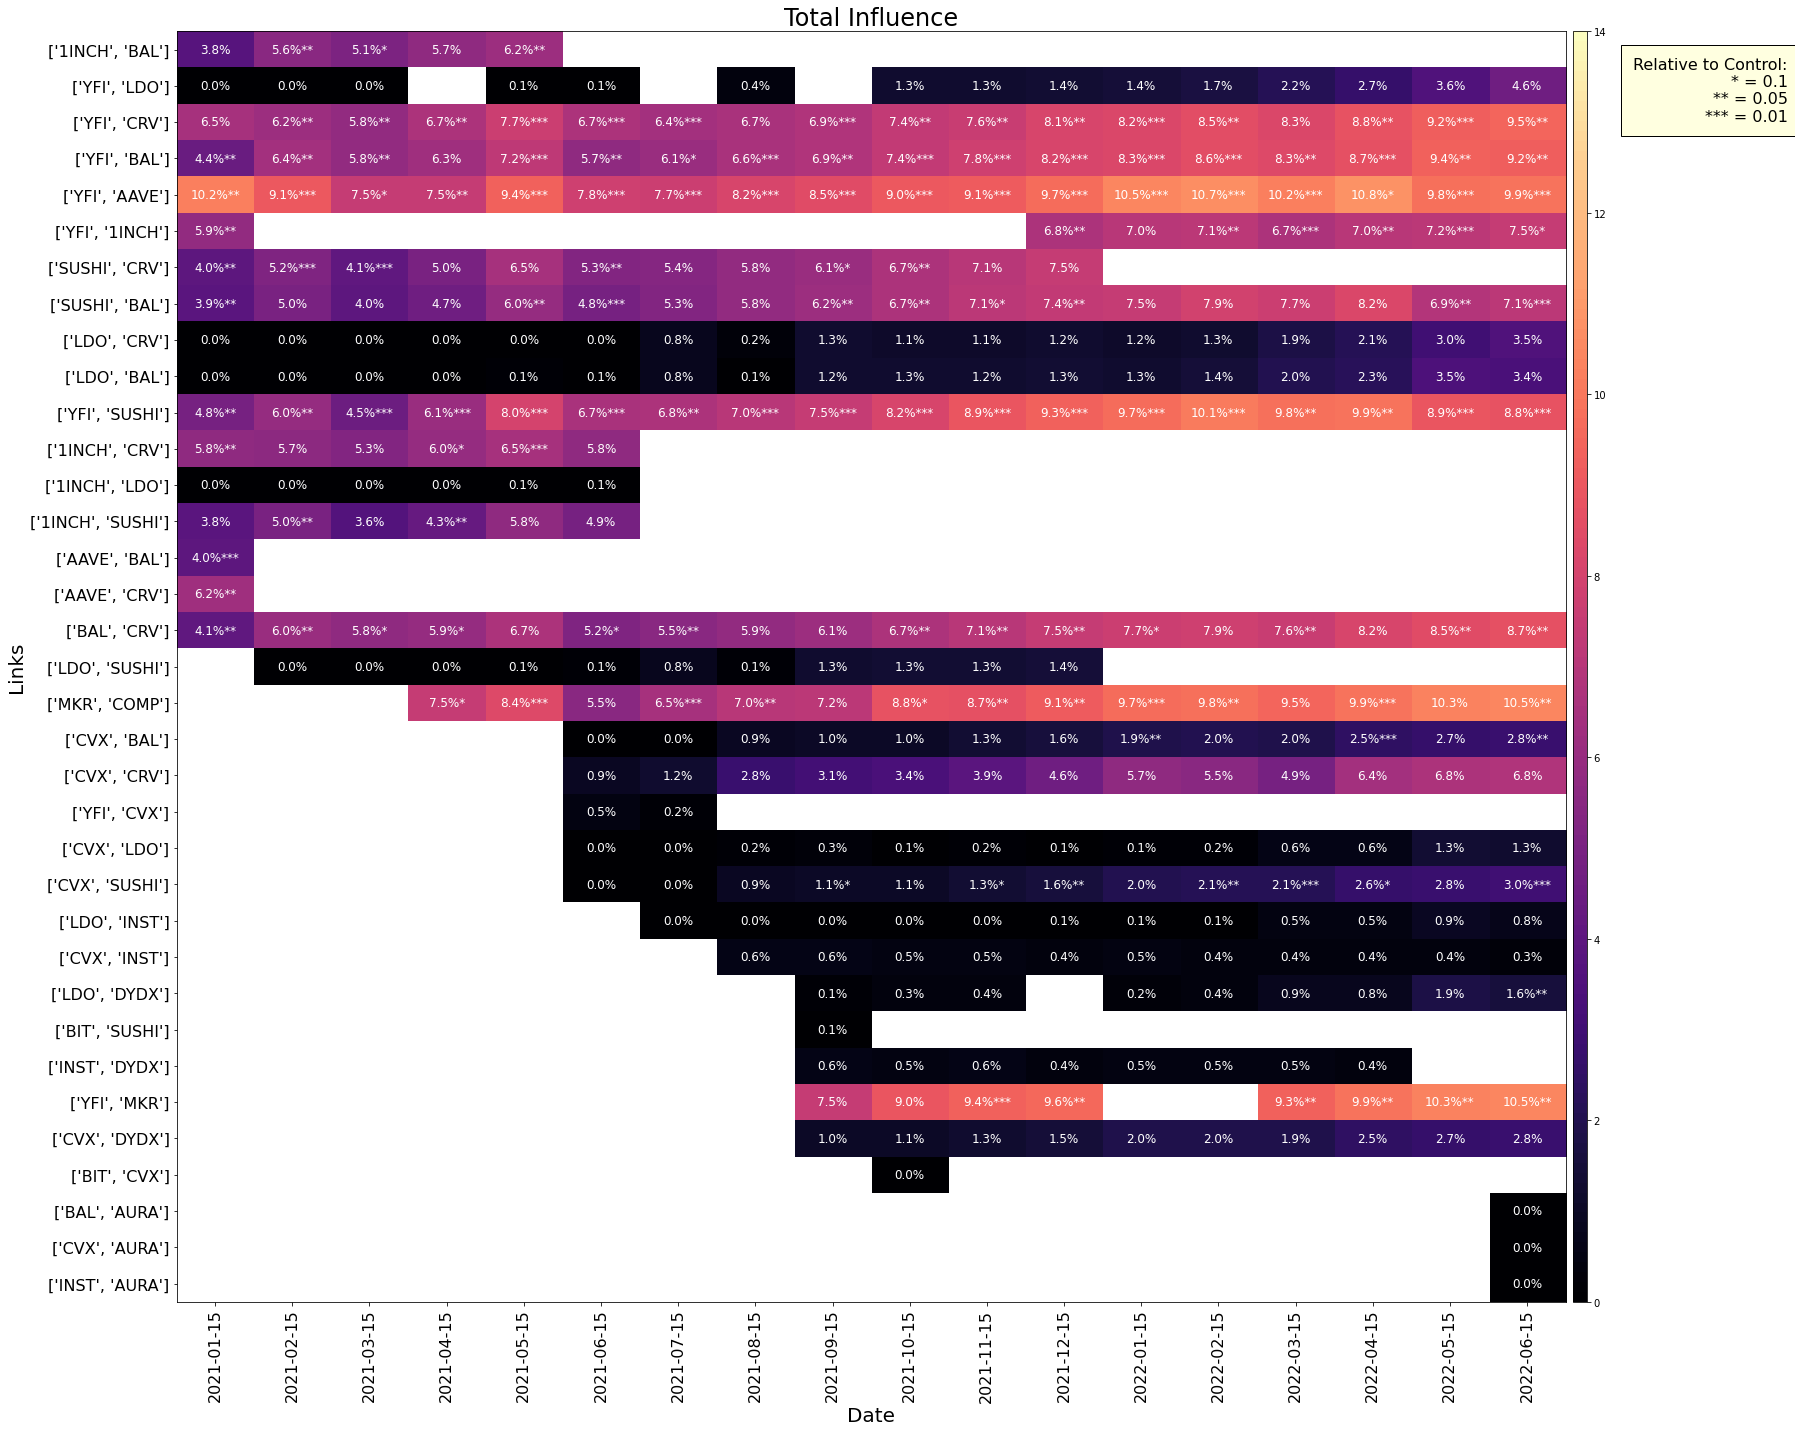

In [5]:
plot_heatmap_chart(metric_dataframes, metric_name='total_influence', pct=True,  log=False, output_path="../output/links/", save=False, show=True)

### Fig: gini_total_influence

In [ ]:
plot_boxplot_with_significance(metric_dataframes, metric='gini_total_influence', unit='', group='sample', output_path="../output/links/", save=True, show=True)

### Fig: internal_influence 

In [ ]:
plot_heatmap_chart(metric_dataframes, metric_name='internal_influence', pct=True,  log=False, output_path="../output/links/", save=False, show=True)

### Fig: gini_internal_influence 

In [ ]:
plot_boxplot_with_significance(metric_dataframes, metric='gini_internal_influence', unit='', group='sample', output_path="../output/links/", save=True, show=True)

### Fig: external_influence

In [ ]:
plot_heatmap_chart(metric_dataframes, metric_name='external_influence', pct=True, log=False, output_path="../output/links/", save=False, show=True)

### Fig: gini_external_influence

In [ ]:
plot_boxplot_with_significance(metric_dataframes, metric='gini_external_influence', unit='', group='sample', output_path="../output/links/", save=True, show=True)

### Fig: wealth_clique


In [ ]:
plot_heatmap_chart(metric_dataframes, metric_name='wealth_link', pct=False, log=True, output_path="../output/links/", save=False, show=True)

### Fig: gini_wealth_clique

In [ ]:

plot_boxplot_with_significance(metric_dataframes, metric='wealth_link', unit='', group='sample', output_path="../output/links/", save=True, show=True)


### Fig: median_no_assets_link


In [ ]:
plot_heatmap_chart(metric_dataframes, metric_name='median_no_assets_link', pct=False, log=True, output_path="../output/links/", save=False, show=True)

### Fig: Distribution of Labels

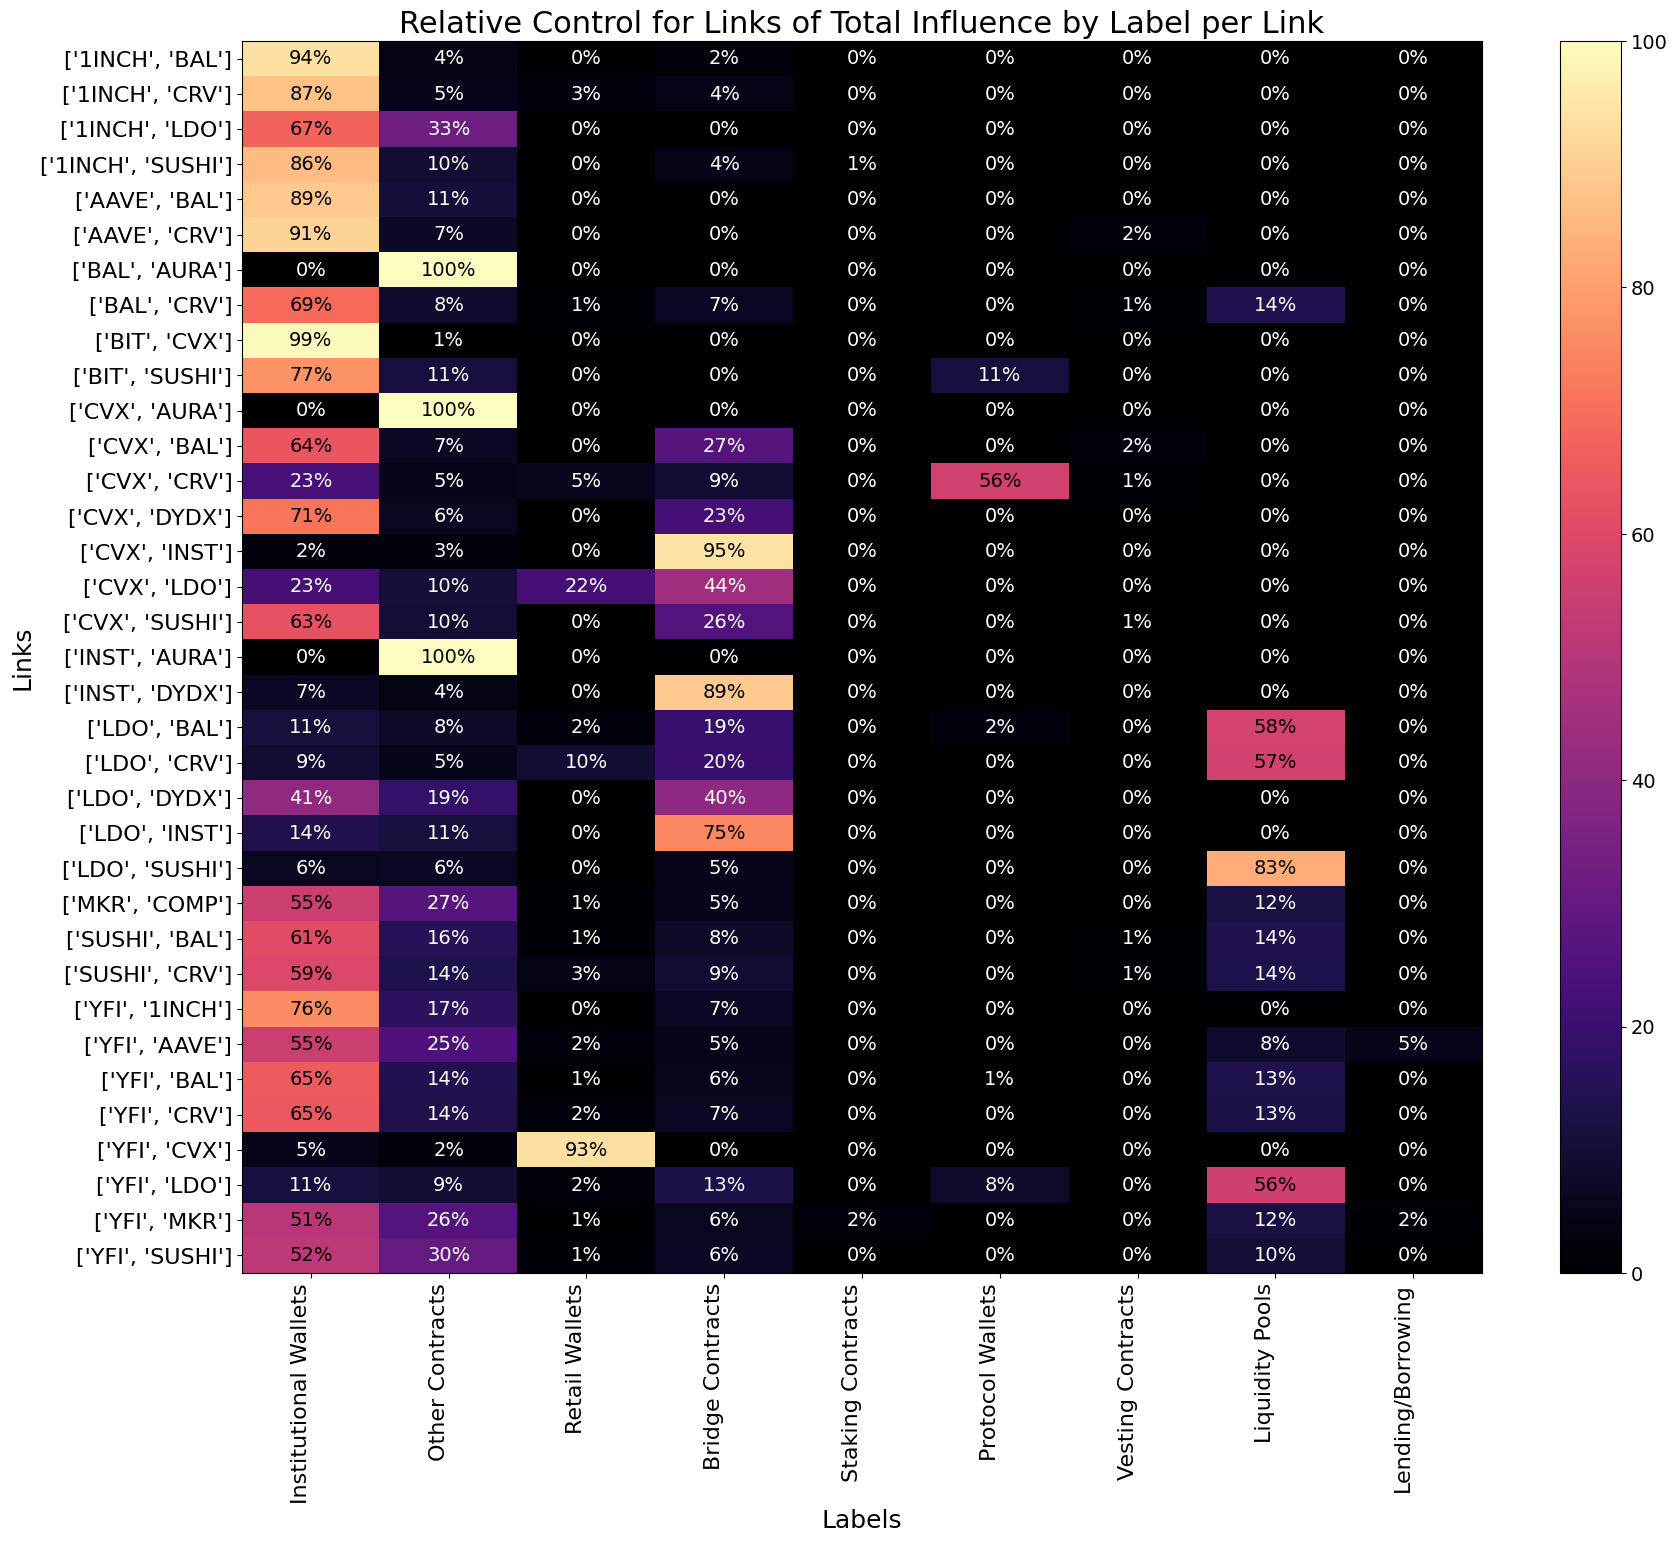

In [14]:
plot_heatmap_labels(metric_dataframes, group='sample', colormap='magma', output_path='../output/links')